https://www.tensorflow.org/hub/tutorials/object_detection

In [1]:
IMAGE_PATH = "./video_utils/videos/video_1_cut/frame_01249.jpg"

MODULE_HANDLE = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
#@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_hub as hub
import time

In [3]:
x = np.arange(1080)
heights = [750,516,376,360,336,330,321,317,312,309]
distances = [0,4,16,20,24,36,40,52,56,70]
heights.reverse()
distances.reverse()
interpolated_distances = np.interp(x, heights, distances)

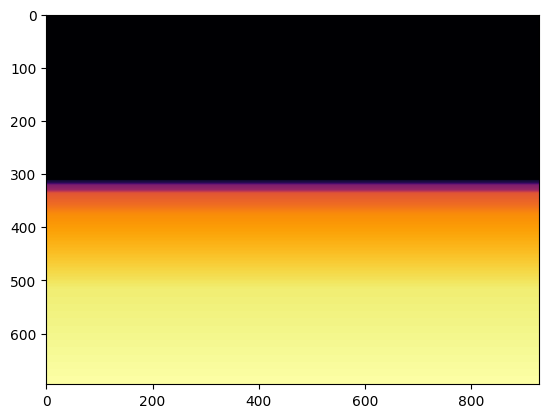

In [4]:
depth = np.zeros((1080, 1920), dtype=np.float32)

for h in range(311, 751):
    depth[h,:] = interpolated_distances[h]

depth[:311,:] = depth[311, 0]

depth_target_rectangle = depth[0:696, (1920 - 928) // 2 : (1920 + 928) // 2]

plt.imshow(depth_target_rectangle, cmap=plt.get_cmap('inferno_r'))

In [5]:
def detect(detector, path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Time: ", end_time-start_time)

    return result

In [6]:
detector = hub.load(MODULE_HANDLE).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
image = cv2.imread(IMAGE_PATH)
image2 = image[:696, (1920 - 928) // 2 : (1920 + 928) // 2, :]
cv2.imwrite("tmp.jpg", image2)

True

In [8]:
result = detect(detector, "tmp.jpg")

Found 100 objects.
Time:  37.80834603309631


In [9]:
result = detect(detector, "tmp.jpg")

Found 100 objects.
Time:  1.3456459045410156


[0.36631018 0.63109434 0.57742673 0.875827  ] b'Car' 0.99271


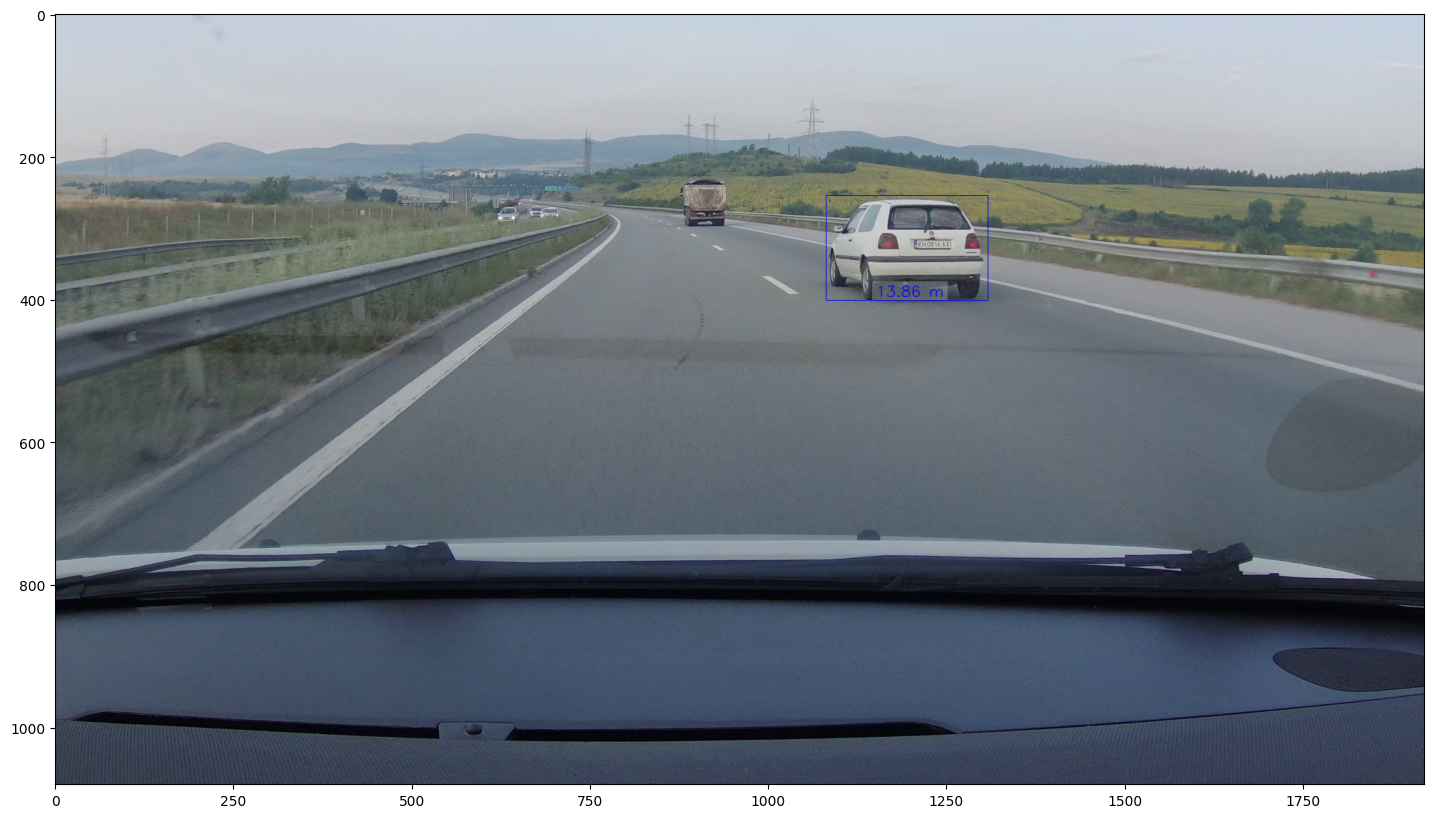

In [10]:
image = cv2.imread(IMAGE_PATH)

font = cv2.FONT_HERSHEY_SIMPLEX 
font_scale = 0.7
color = (255, 0, 0) 
thickness = 1

for i in range(len(result["detection_boxes"])):
    if result["detection_scores"][i] > 0.75:
        if not (result["detection_class_entities"][i] in [b"Car", b"Bus", b"Truck"]):
            continue
        print(result["detection_boxes"][i], result["detection_class_entities"][i], result["detection_scores"][i])
        top    = int(result["detection_boxes"][i][0] * 696)
        left   = int(result["detection_boxes"][i][1] * 928)
        bottom = int(result["detection_boxes"][i][2] * 696)
        right  = int(result["detection_boxes"][i][3] * 928)
        if bottom >= 309:
            start_point = (left + (1920 - 928) // 2, top)
            end_point = (right + (1920 - 928) // 2, bottom)

            image = cv2.rectangle(image, start_point, end_point, color, thickness)

            dist = interpolated_distances[bottom]
            text = f"{dist:.2f} m"
            text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
            text_pos = (start_point[0] + (right - left - text_size[0] + 10) // 2, end_point[1] - text_size[1] - 5)
            rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255
            alpha = 0.75
            try:
                image[text_pos[1] - 5 : text_pos[1] + text_size[1] + 5,
                      text_pos[0] - 5 : text_pos[0] + text_size[0] + 5] = \
                    cv2.addWeighted(image[text_pos[1] - 5 : text_pos[1] + text_size[1] + 5,
                                          text_pos[0] - 5 : text_pos[0] + text_size[0] + 5],
                                    alpha, rectangle, 1 - alpha, 0)
                image = cv2.putText(image, text,
                                     (text_pos[0], text_pos[1] + text_size[1]), font,
                                     font_scale, color, thickness, cv2.LINE_AA)
            except:
                pass

plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))